## Explore NH data - working with nh_data_subset.parquet file

In [17]:
import pandas as pd
import re
import os
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt

In [190]:
pd.set_option('display.max_columns', None)

### nursing home deficiency data

In [18]:
nh1=pq.read_table("nh_data_subset.parquet")

### collect Deficiency look up table 
source - https://data.cms.gov/provider-data/dataset/tagd-9999#overview

In [34]:
def_tag = pd.read_csv(
    '/Users/sandeep/Downloads/def_tags_2024.csv')
def_tag.head(2)

,Deficiency Prefix,Deficiency Tag Number,Deficiency Prefix and Number,Deficiency Description,Deficiency Category
0,E,1,E-0001,Establish an Emergency Preparedness Program (EP).,Emergency Preparedness Deficiencies
1,E,4,E-0004,Develop and maintain an Emergency Preparedness...,Emergency Preparedness Deficiencies


In [29]:
def_tag_pa = pa.Table.from_pandas(def_tag)
def_tag_pa['Deficiency Tag Number'].type

DataType(int64)

### combine nh data with deficiency label for descriptions

In [32]:
nh1 = nh1.append_column(
    'year_inspection', pa.compute.year(nh1['inspection_date']))

In [30]:
nh1 = nh1.append_column('deficiency_tag1', pa.compute.cast(
    nh1['deficiency_tag'], pa.int64()))

nh1 = nh1.join(def_tag_pa, 'deficiency_tag1', 'Deficiency Tag Number')

In [33]:
nh1.group_by(['year_inspection']
             ).aggregate([("bedcert", "count")]
                         ).combine_chunks().sort_by('year_inspection'
                                                    ).to_pandas()

,year_inspection,bedcert_count
0,2013,26
1,2014,416
2,2015,16248
3,2016,123301
4,2017,145749
5,2018,129663
6,2019,25203


In [35]:
a_table = nh1.group_by(['Deficiency Category', 'year_inspection']
                       ).aggregate([("bedcert", "count")]
                                   ).combine_chunks().sort_by('year_inspection'
                                                              ).to_pandas()

,Deficiency Category,year_inspection,bedcert_count
20,Laboratories Deficiencies,2014,1
21,Fire Alarm Systems Deficiencies,2014,1
22,Nursing and Physician Services Deficiencies,2014,9
23,Services Deficiencies,2014,2
24,Quality of Life and Care Deficiencies,2015,2802


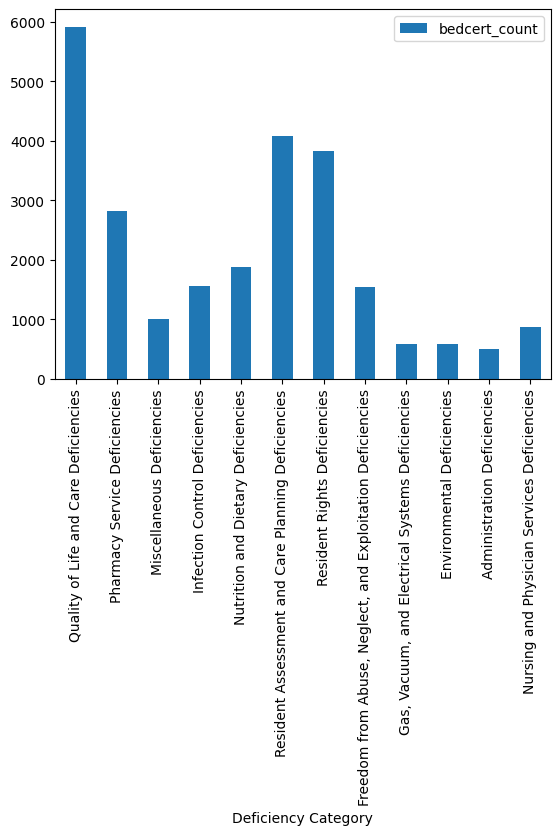

In [191]:
a_table[a_table['year_inspection']==2019].plot(x='Deficiency Category', y='bedcert_count', kind='bar')
a_table.iloc[20:25]

In [38]:
pd.pivot_table(a_table, index='Deficiency Category',
               columns='year_inspection',
               values='bedcert_count')

year_inspection,2013,2014,2015,2016,2017,2018,2019
Deficiency Category,,,,,,,
Administration Deficiencies,NaN,17.0,717.0,6073.0,7048.0,3035.0,496.0
Automatic Sprinkler Systems Deficiencies,NaN,2.0,20.0,263.0,284.0,1.0,NaN
Construction Deficiencies,NaN,NaN,2.0,27.0,52.0,NaN,NaN
Egress Deficiencies,3.0,31.0,1529.0,13081.0,14932.0,86.0,NaN
Environmental Deficiencies,6.0,58.0,2199.0,17719.0,19729.0,3511.0,591.0
Fire Alarm Systems Deficiencies,NaN,1.0,67.0,372.0,437.0,2.0,NaN
"Freedom from Abuse, Neglect, and Exploitation Deficiencies",1.0,9.0,504.0,5715.0,7731.0,8300.0,1541.0
"Gas, Vacuum, and Electrical Systems Deficiencies",NaN,NaN,NaN,NaN,215.0,3435.0,591.0
Infection Control Deficiencies,NaN,NaN,NaN,NaN,494.0,7894.0,1566.0


In [150]:
a_table.sort_values(['bedcert_count'], ascending=False)[:10]

,Deficiency Category,year_inspection,bedcert_count
76,Quality of Life and Care Deficiencies,2018,30237
57,Quality of Life and Care Deficiencies,2017,24807
85,Resident Assessment and Care Planning Deficien...,2018,21122
40,Quality of Life and Care Deficiencies,2016,20820
58,Smoke Deficiencies,2017,20406
79,Resident Rights Deficiencies,2018,19850
59,Environmental Deficiencies,2017,19729
41,Smoke Deficiencies,2016,18763
43,Environmental Deficiencies,2016,17719
56,Egress Deficiencies,2017,14932


In [70]:
#new_nh_data = pd.read_csv("/Users/sandeep/Downloads/NH_HealthCitations_Apr2024.csv", encoding='latin-1')
#new_nh_data.columns = new_nh_data.columns.str.lower().str.replace(' ','_')
#new_nh_data['survey_date'] = pd.to_datetime(new_nh_data['survey_date'])

In [85]:
pa.compute.max(nh1['inspection_date'])

<pyarrow.TimestampScalar: '2019-04-18T00:00:00.000000'>

In [142]:
pa.compute.min(nh1['inspection_date'])

<pyarrow.TimestampScalar: '2013-03-19T00:00:00.000000'>

### dataset between 2016 thru 2019

In [80]:
filt = (pa.compute.field('year_inspection')>2016) & (pa.compute.field('year_inspection') <=2019)

In [81]:
nh_16_19=nh1.filter(filt)

In [83]:
nh_16_19 = nh_16_19.to_pandas()

In [325]:
#nh_16_19.columns

### what is  the question of interest?
Begin on the new Biden policy of minimum staff mandate. How will the minimum staff mandate impact the NH industry. An increase in staff required will impact profitability, which may then impact viability, sizes, bed counts, mergers, closures, etc.

In [126]:
cols = ['facility_id', 'state', 'zip', 'inspection_date', 'deficiency_tag',
       'scope_severity', 'complaint', 'standard', 'eventid', 'county_ssa',
       'county_name', 'ownership', 'bedcert', 'restot', 'certification',
       'inhosp', 'lbn', 'participation_date', 'ccrc_facil', 'sffstatus',
       #'oldsurvey', 'chow_last_12mos', 'resfamcouncil', 'sprinkler_status',
       'staffing_flag', 'pt_staffing_flag',
        #'aidhrd', 'vochrd', 'rnhrd',
       #'totlichrd', 'tothrd', 'pthrd', 'cm_aide', 'cm_lpn', 'cm_rn',
       #'cm_total', 'adj_aide', 'adj_lpn', 'adj_rn', 'adj_total',
       'year_inspection']

In [263]:
nh1619sub = nh_16_19[cols].copy()

In [264]:
nh1619sub=nh1619sub.drop_duplicates() # drop dupes

#### times investigated in a year & tags per inspection

In [330]:
nh1619sub['inspections_per_year']=nh1619sub.groupby(["facility_id",
                                                     "year_inspection"])['eventid'].transform(lambda x: len(x.unique()))
nh1619sub['tags_per_inspection']=nh1619sub.groupby(["facility_id","year_inspection","eventid"])['deficiency_tag'].transform(lambda x: len(x.unique()))

In [333]:
#nh1619sub.groupby(["facility_id","year_inspection","eventid"]).nunique()['deficiency_tag'].reset_index()#[nh1619sub.groupby(["facility_id","year_inspection","eventid"]).nunique()['deficiency_tag'].reset_index()['facility_id']=='045267']
#nh1619sub.groupby(["facility_id","year_inspection"]).nunique()['eventid']

In [331]:
# testing code..
nh1619sub.loc[nh1619sub['facility_id']=='045267' ,['facility_id','year_inspection','eventid','inspection_date','deficiency_tag','test','test2',
                                                  'inspections_per_year','tags_per_inspection']]

,facility_id,year_inspection,eventid,inspection_date,deficiency_tag,test,test2,inspections_per_year,tags_per_inspection
0,045267,2018,47ON11,2018-04-13,600,2,8.0,2,8.0
1,045267,2018,47ON11,2018-04-13,607,2,8.0,2,8.0
2,045267,2018,47ON11,2018-04-13,609,2,8.0,2,8.0
3,045267,2018,47ON11,2018-04-13,610,2,8.0,2,8.0
4,045267,2018,47ON11,2018-04-13,689,2,8.0,2,8.0
5,045267,2018,47ON11,2018-04-13,835,2,8.0,2,8.0
6,045267,2018,47ON11,2018-04-13,880,2,8.0,2,8.0
7,045267,2019,W9FG11,2019-01-11,684,1,8.0,1,8.0
8,045267,2019,W9FG11,2019-01-11,686,1,8.0,1,8.0
9,045267,2019,W9FG11,2019-01-11,695,1,8.0,1,8.0


In [274]:
nh1619sub.loc[nh1619sub['facility_id']=='145371',['facility_id','inspections_per_year','year_inspection','eventid','inspection_date','deficiency_tag']]

KeyError: "['inspections_per_year'] not in index"

In [249]:
nh1619sub.shape

(253816, 26)